### Robust Principal Component Analysis of Sonal Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from numpy.linalg import inv, eig, pinv
from scipy import linalg
from scipy import pi, multiply, power, tanh, exp, cosh
from scipy import random

In [2]:
# This is the pcp(Principal Projection Pursuit) function from https://github.com/dfm/pcp

"""
An implementation of the Principal Component Pursuit algorithm for robust PCA
as described in `Candes, Li, Ma, & Wright <http://arxiv.org/abs/0912.3599>`_.
An alternative Python implementation using non-standard dependencies and
different hyperparameter choices is available at:
http://blog.shriphani.com/2013/12/18/
    robust-principal-component-pursuit-background-matrix-recovery/
"""

from __future__ import division, print_function

__all__ = ["pcp"]

import time
# import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-6, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        # step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.sqrt(np.sum(step ** 2) / norm)
        if verbose:
            print(("Iteration {0}: error={1:.3e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if err < delta:
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S


def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

In [4]:
# Reading 2-month sonar time series
import h5py
f = h5py.File('../data/20150817-20151017_MVBS.h5',"r")

In [5]:
ping_per_day_mvbs = 144

In [6]:
MVBS = np.array(f['MVBS'])
# converting to linear domain
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [7]:
%%time
# applying pcp to the data in log domain (i.e. the way data comes from ooi)
L, S, (u,s,v) = pcp(10*np.log10(mvbs_long),maxiter=500, verbose=False,svd_method="exact")

CPU times: user 42.3 s, sys: 3.89 s, total: 46.2 s
Wall time: 11.8 s


In [8]:
# a function for transforming the data for plotting
def separate_transform_result(D,ori_data,ping_per_day_mvbs,log_opt=1):
    '''
    Separate transformed results into different frequencies and 
    for use with `plot_cmp_data_decomp` and `plot_single_day`
    '''
    D_long = D.reshape((D.shape[0],-1,ori_data.shape[1])).swapaxes(1,2)
    D_sep = D_long.reshape((D_long.shape[0],D_long.shape[1],-1,ping_per_day_mvbs)).transpose((2,0,1,3))
    if log_opt==1:
        D_plot = 10*np.log10(D_sep.transpose((0,2,1,3))).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    else:
        D_plot = D_sep.transpose((0,2,1,3)).reshape((D_sep.shape[0],D_sep.shape[2],-1))
    return D_sep,D_plot

In [9]:
L_sep, L_plot = separate_transform_result(L,mvbs,ping_per_day_mvbs,log_opt = 0)
S_sep, S_plot = separate_transform_result(S,mvbs,ping_per_day_mvbs,log_opt = 0)

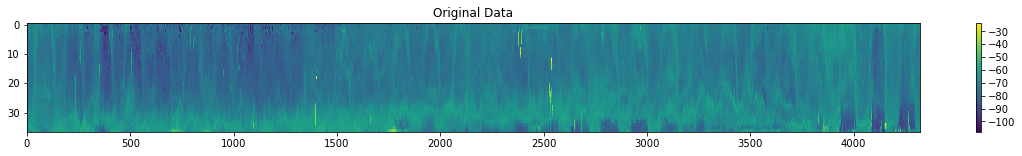

In [10]:
# plotting the raw data
plt.figure(figsize = (20,2))
plt.imshow(10*np.log10(mvbs[0,:,:30*144]), aspect='auto')
plt.title('Original Data')
plt.colorbar()

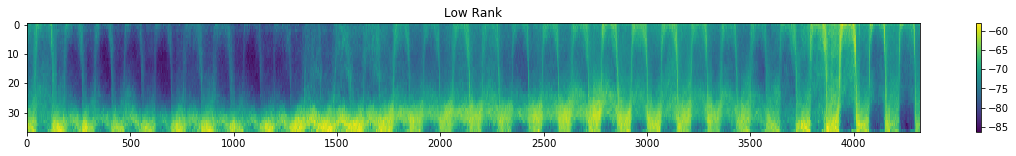

In [11]:
plt.figure(figsize = (20,2))
plt.imshow(L_plot[0,:,:144*30], aspect = 'auto')#,vmax = -30,vmin = -80)
plt.title('Low Rank')
plt.colorbar()

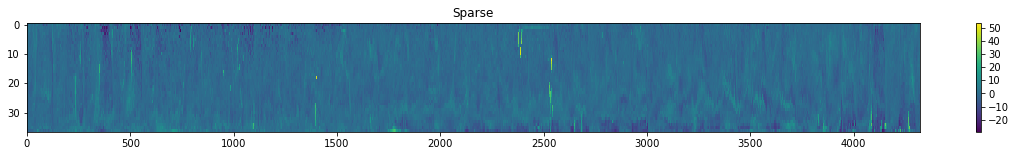

In [12]:
plt.figure(figsize = (20,2))
plt.imshow(S_plot[0,:,:144*30], aspect = 'auto')#,vmax = -30,vmin = -80)
plt.title('Sparse')
plt.colorbar()

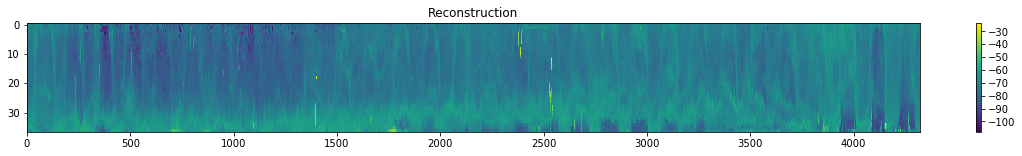

In [13]:
plt.figure(figsize = (20,2))
plt.imshow(S_plot[0,:,:144*30]+L_plot[0,:,:144*30], aspect = 'auto')#,vmax = -30,vmin = -80)
plt.title('Reconstruction')
plt.colorbar()

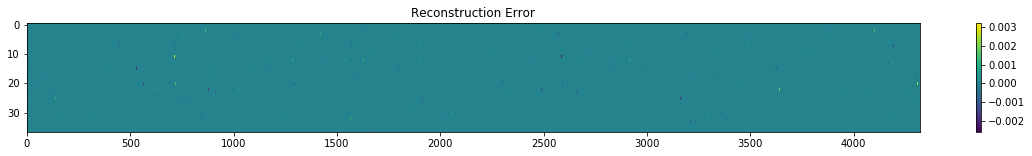

In [14]:
plt.figure(figsize = (20,2))
plt.imshow(10*np.log10(mvbs[0,:,:30*144]) - S_plot[0,:,:144*30]- L_plot[0,:,:144*30], aspect = 'auto')#,vmax = -30,vmin = -80)
plt.title('Reconstruction Error')
plt.colorbar()
